In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download msambare/fer2013

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
! unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping


In [14]:
train_dir = "/content/train"  # train data folder
test_dir = "/content/test"    # test data folder

In [15]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
      
        for filename in os.listdir(directory+"/"+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels

In [16]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_dir)
train.head()

,image,label
0,/content/train/sad/Training_49447489.jpg,sad
1,/content/train/sad/Training_88655888.jpg,sad
2,/content/train/sad/Training_3895022.jpg,sad
3,/content/train/sad/Training_89300824.jpg,sad
4,/content/train/sad/Training_29733068.jpg,sad


In [17]:
train.tail()

,image,label
28704,/content/train/angry/Training_90466903.jpg,angry
28705,/content/train/angry/Training_48614073.jpg,angry
28706,/content/train/angry/Training_64992219.jpg,angry
28707,/content/train/angry/Training_31569221.jpg,angry
28708,/content/train/angry/Training_44516923.jpg,angry


In [18]:
train.shape

(28709, 2)

In [19]:
train['label'].value_counts()

happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: label, dtype: int64

In [20]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_dir)
test.head()

,image,label
0,/content/test/sad/PublicTest_2910538.jpg,sad
1,/content/test/sad/PrivateTest_94749295.jpg,sad
2,/content/test/sad/PrivateTest_65546158.jpg,sad
3,/content/test/sad/PrivateTest_47129405.jpg,sad
4,/content/test/sad/PublicTest_95266818.jpg,sad


In [21]:
test.shape

(7178, 2)

In [22]:
test['label'].value_counts()

happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
disgust      111
Name: label, dtype: int64

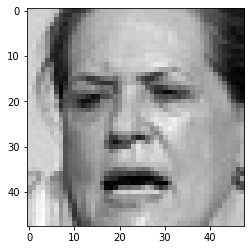

In [23]:
from PIL import Image
# Load image using Pillow
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

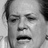

In [24]:
img

In [25]:
shape = img.size + img.getbands() 
print("The shape of the image is:", shape)

The shape of the image is: (48, 48, 'L')


In [26]:
def resizing(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [27]:
train_features = resizing(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [28]:
train_features.shape

(28709, 48, 48, 1)

In [29]:
test_features = resizing(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [30]:
test_features.shape

(7178, 48, 48, 1)

In [31]:
## normalize the image
x_train = train_features/255
x_test = test_features/255

In [32]:
## Encoding the output column (label)

from sklearn.preprocessing import LabelEncoder
la = LabelEncoder()
la.fit(train['label'])
y_train = la.transform(train['label'])
y_test = la.transform(test['label'])

In [33]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [34]:
y_train[0], y_train[-1]

(array([0., 0., 0., 0., 0., 1., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [35]:
input_shape = (48, 48, 1)
output_class = 7

In [36]:
model = Sequential()

# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [37]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [38]:
# train the model
history = model.fit(x = x_train, y = y_train, batch_size = 32, epochs = 100, validation_data=(x_test, y_test))

Epoch 1/100
898/898 [==============================] - 27s 17ms/step - loss: 1.7970 - accuracy: 0.2577 - val_loss: 1.7025 - val_accuracy: 0.3137
Epoch 2/100
898/898 [==============================] - 15s 16ms/step - loss: 1.6496 - accuracy: 0.3421 - val_loss: 1.5090 - val_accuracy: 0.4071
Epoch 3/100
898/898 [==============================] - 15s 17ms/step - loss: 1.5306 - accuracy: 0.3993 - val_loss: 1.3999 - val_accuracy: 0.4611
Epoch 4/100
898/898 [==============================] - 15s 16ms/step - loss: 1.4680 - accuracy: 0.4323 - val_loss: 1.3500 - val_accuracy: 0.4733
Epoch 5/100
898/898 [==============================] - 15s 17ms/step - loss: 1.4179 - accuracy: 0.4538 - val_loss: 1.3092 - val_accuracy: 0.4907
Epoch 6/100
898/898 [==============================] - 15s 17ms/step - loss: 1.3786 - accuracy: 0.4692 - val_loss: 1.2818 - val_accuracy: 0.5070
Epoch 7/100
898/898 [==============================] - 15s 17ms/step - loss: 1.3504 - accuracy: 0.4783 - val_loss: 1.2742 - val_ac

In [39]:
history = model.fit(x = x_train, y = y_train, batch_size = 32, epochs = 20, validation_data=(x_test, y_test),callbacks=[early_stop])

Epoch 1/20
898/898 [==============================] - 15s 17ms/step - loss: 0.7246 - accuracy: 0.7432 - val_loss: 1.1128 - val_accuracy: 0.6030
Epoch 2/20
898/898 [==============================] - 15s 17ms/step - loss: 0.7356 - accuracy: 0.7384 - val_loss: 1.1189 - val_accuracy: 0.6106
Epoch 3/20
898/898 [==============================] - 15s 17ms/step - loss: 0.7200 - accuracy: 0.7428 - val_loss: 1.1260 - val_accuracy: 0.5989
Epoch 4/20
898/898 [==============================] - 15s 17ms/step - loss: 0.7255 - accuracy: 0.7402 - val_loss: 1.1069 - val_accuracy: 0.6096
Epoch 5/20
898/898 [==============================] - 15s 17ms/step - loss: 0.7126 - accuracy: 0.7483 - val_loss: 1.1151 - val_accuracy: 0.6046
Epoch 6/20
898/898 [==============================] - 15s 16ms/step - loss: 0.7116 - accuracy: 0.7473 - val_loss: 1.1160 - val_accuracy: 0.6038
Epoch 7/20
898/898 [==============================] - 15s 16ms/step - loss: 0.7018 - accuracy: 0.7494 - val_loss: 1.1197 - val_accuracy:

Original Output: happy
1/1 [==============================] - 0s 227ms/step
Predicted Output: neutral


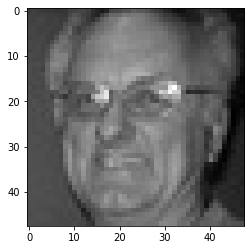

In [40]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = la.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index], cmap='gray');

Original Output: surprise
1/1 [==============================] - 0s 36ms/step
Predicted Output: happy


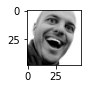

In [41]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = la.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.subplots(figsize=(1, 1))
plt.imshow(x_test[image_index], cmap='gray');


Original Output: happy
1/1 [==============================] - 0s 29ms/step
Predicted Output: happy


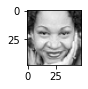

In [42]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = la.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.subplots(figsize=(1,1))
plt.imshow(x_test[image_index], cmap='gray');

Original Output: surprise
1/1 [==============================] - 0s 24ms/step
Predicted Output: surprise


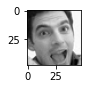

In [43]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = la.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.subplots(figsize=(1,1))
plt.imshow(x_test[image_index], cmap='gray');

In [45]:

# import required packages
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '/content/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '/content/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

# save model structure in jason file
model_json = emotion_model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model.h5')



Found 28709 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.
Epoch 1/50
448/448 [==============================] - 21s 45ms/step - loss: 1.7958 - accuracy: 0.2641 - val_loss: 1.6903 - val_accuracy: 0.3477
Epoch 2/50
448/448 [==============================] - 20s 44ms/step - loss: 1.6101 - accuracy: 0.3741 - val_loss: 1.5149 - val_accuracy: 0.4198
Epoch 3/50
448/448 [==============================] - 19s 43ms/step - loss: 1.5097 - accuracy: 0.4208 - val_loss: 1.4333 - val_accuracy: 0.4559
Epoch 4/50
448/448 [==============================] - 20s 45ms/step - loss: 1.4386 - accuracy: 0.4468 - val_loss: 1.3586 - val_accuracy: 0.4837
Epoch 5/50
448/448 [==============================] - 20s 44ms/step - loss: 1.3740 - accuracy: 0.4761 - val_loss: 1.3024 - val_accuracy: 0.5131
Epoch 6/50
448/448 [==============================] - 19s 43ms/step - loss: 1.3231 - accuracy: 0.4982 - val_loss: 1.2458 - val_accuracy: 0.5347
Epoch 7/50
448/448 [==============================

In [48]:
import cv2
import numpy as np
from keras.models import model_from_json


emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# load json and create model
json_file = open('/content/emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

# load weights into new model
emotion_model.load_weights("/content/emotion_model.h5")
print("Loaded model from disk")

# start the webcam feed
cap = cv2.VideoCapture(0)

# pass here your video path
# you may download one from here : https://www.pexels.com/video/three-girls-laughing-5273028/
#cap = cv2.VideoCapture('C:/Users/user/Videos/Captures/production_ID_5198164')

while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    #frame = cv2.resize(frame, (1280, 720))
    if not ret:
        break
    face_detector = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # detect faces available on camera
    num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    # take each face available on the camera and Preprocess it
    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)

        # predict the emotions
        emotion_prediction = emotion_model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Loaded model from disk
